In [5]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
!pip install kaucherpy
from kaucherpy import *
import seaborn as sns
import copy

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def sti_vector(vec_inf, vec_sup):
    return np.append(-vec_inf, vec_sup)

In [9]:
def back_sti_vector(sti_vec):  
    mid_idx = sti_vec.shape[0] // 2
    return -sti_vec[:mid_idx], sti_vec[mid_idx:]

In [10]:
def sti_dot_mtx(matrix):
    pos = matrix.copy()
    neg = matrix.copy()
    pos[pos < 0] = 0
    neg[neg > 0] = 0
    neg = np.fabs(neg)
    return np.block([[pos, neg], [neg, pos]])

In [11]:
def compute_sub_grad(D, i, j, A_inf, A_sup, b_inf, b_sup):
    n = D.shape[0] // 2;
    ainf = A_inf[i][j]
    asup = A_sup[i][j]
    

    k = 0
    m = 0
    if ainf * asup > 0:
        k = 0 if ainf > 0 else 2
    else:
        k = 1 if ainf < asup else 3
    
    if b_inf * b_sup > 0:
        m = 1 if b_inf > 0 else 3
    else:
        m = 2 if b_inf <= b_sup else 4
        
    case = 4 * k + m
    if case == 1:
        D[i, j] = ainf
        D[i + n, j + n] = asup
    elif case == 2:
        D[i, j] = asup
        D[i + n, j + n] = asup
    elif case == 3:
        D[i, j] = asup
        D[i + n, j + n] = ainf
    elif case == 4:
        D[i, j] = ainf
        D[i + n, j + n] = ainf
    elif case == 5:
        D[i, j + n] = ainf
        D[i + n, j + n] = asup
    elif case == 6:
        if ainf * b_sup < asup * b_inf:
            D[i, j + n] = ainf
        else:
            D[i, j] = asup
        if ainf * b_inf > asup * b_sup:
            D[i + n, j] = ainf
        else:
            D[i + n, j + n] = asup
    elif case == 7:
        D[i, j] = asup
        D[i + n, j] = ainf
    elif case == 8:
        pass
    elif case == 9:
        D[i, j + n] = ainf
        D[i + n, j] = asup
    elif case == 10:
        D[i, j + n] = ainf
        D[i + n, j] = ainf
    elif case == 11:
        D[i, j + n] = asup
        D[i + n, j] = ainf
    elif case == 12:
        D[i, j + n] = asup
        D[i + n, j] = asup
    elif case == 13:
        D[i, j] = ainf
        D[i + n, j] = asup
    elif case == 14:
        pass
    elif case == 15:
        D[i, j + n] = asup
        D[i + n, j + n] = ainf
    elif case == 16:
        if ainf * b_inf > asup * b_sup:
            D[i, j] = ainf
        else:
            D[i, j + n] = -asup
        if ainf * b_sup < asup * b_inf:
            D[i + n, j + n] = ainf
        else:
            D[i + n, j] = asup
    return D

In [12]:
def compute_func_value(A_inf, A_sup, cur_point, sti_vec):
    n=A_inf.shape[0]
    C_mtx = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
    intervaled_inf, intervaled_sup = back_sti_vector(cur_point)
    y_interval = [Kaucher(intervaled_inf[i], intervaled_sup[i]) for i in range(intervaled_inf.shape[0])]
    dot_prod = [sum([C_mtx[i][j] * y_interval[j] for j in range(len(y_interval))]) for i in range(len(C_mtx))]
    prod_lower = np.array([comp.lower for comp in dot_prod])
    prod_upper = np.array([comp.upper for comp in dot_prod])
    
    return sti_vector(prod_lower, prod_upper) - sti_vec

In [13]:
def sub_diff_method(A_inf, A_sup, b_inf, b_sup, lr=0.08, acc=1e-10, max_iter=1000):
    
    n = A_inf.shape[0]  # dim
    
    A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
    A_blok = sti_dot_mtx(A_mid)
    sti_vec = sti_vector(b_inf, b_sup) 
    
    cur_x = np.zeros(sti_vec.shape[0]) 
    
    prev_x = cur_x
    started = False  


    cur_iter = 0
    worklist = [cur_x] 
    while not started or np.linalg.norm(cur_x - prev_x) > acc:
        started = True
        cur_iter += 1
        if (cur_iter > max_iter):
            print("Too many iterations")
            break
        prev_x = cur_x 
        D = np.zeros((2 * n, 2 * n)) 
        
        for i in range(n):
            for j in range(n):    
                
                h_inf = -prev_x[j]
                h_sup = prev_x[j + n]
                
                D = compute_sub_grad(D, i, j, A_inf, A_sup, h_inf, h_sup)
        
        
        f_v = compute_func_value(A_inf, A_sup, prev_x, sti_vec)

        dx = np.linalg.solve(D, -f_v)

        cur_x = prev_x + lr * dx

        worklist.append(cur_x)
        
    print(f"Iteration count: {cur_iter}")
    return back_sti_vector(cur_x), worklist

In [14]:
def heatMap(matrix, annot=False):
    div = np.max(np.fabs(matrix))
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=annot, center=0)
    plt.title('Matrix coef')
    plt.xlabel('column')
    plt.ylabel('row')
    plt.show()

In [14]:
a_slae_inf = np.array([[0.9, 0.9, 0.9], [0.9, 0.9, 0], [0.9, 0, 0]])
a_slae_sup = np.array([[1.1, 1.1, 1.1], [1.1, 1.1, 0], [1.1, 0, 0]])

inf_b = np.array([2.8, 2.2, 0.9])
sup_b = np.array([3.2, 1.8, 1.1])

(x_inf, x_sup), worklist = sub_diff_method(a_slae_inf, a_slae_sup, inf_b, sup_b)
print(f"X inf: {x_inf}")
print(f"X sup: {x_sup}")

Iteration count: 259
X inf: [1.         1.44444444 0.66666667]
X sup: [1.         0.63636364 1.27272727]


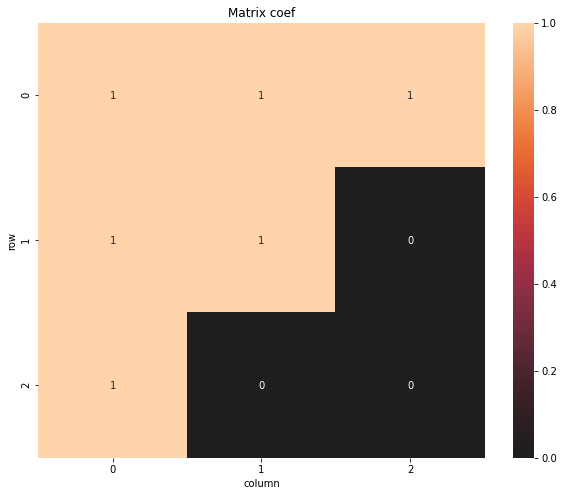

In [15]:
n = a_slae_inf.shape[0]
A_mid = np.array([[(a_slae_inf[i, j] + a_slae_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
heatMap(A_mid, True)

In [15]:
def graphs2(x, x_sup, x_inf, A, b_inf, b_sup):
    plt.figure(figsize=(18, 8))
    plt.plot(np.dot(A, x_inf), label='A * x_inf')
    plt.plot(np.dot(A, x_sup), label='A * x_sup')
    plt.plot(np.dot(A, x), label='b_true')
    plt.plot(b_inf, label='b_inf', ls='--')
    plt.plot(b_sup, label='b_sup', ls='--')
    plt.legend()
    plt.title('Results')
    plt.grid()
    plt.show()

In [16]:
inputs = ['/content/drive/My Drive/matrix_n_phi_1.txt',
         '/content/drive/My Drive/matrix_n_phi_6.txt']

In [17]:
def find_matrix(matrix, size):
    M = matrix
    indexes = []

    for i, col in enumerate(M.T):
        if np.fabs(col).sum() > 0:
            indexes.append(i)
    M = M.T[indexes].T

    size = min(M.shape[0], M.shape[1], size)
    
    while size > 0:
        s = 0
        for i in range(M.shape[0] - size + 1):
            s = 0
            for j in range(M.shape[1] - size + 1):
                s = 0
                if np.linalg.matrix_rank(M[i:i+size, j:j+size]) == size:
                    print(j)
                    break

                s+=1
                #for col in M[i:i+size, j:j+size].T:
                    #if (np.fabs(col).sum() < 0.2): #or (np.fabs(col.T).sum() < 0.1) :
                        #s+=1
                        #break


                #if s == 0:
                    #print(j)
                    #break

            if s == 0:
                print(i)
                break


        if s == 0:
            print(size)
            break

        size -=1
    
    return M[i:i+size, j:j+size], i

In [18]:
def make_interval(A, max_rad=0.001):
    n = A.shape[0]
    rads = np.random.uniform(low=1e-8, high=max_rad, size=(n, n))
    A_inf = A - max_rad
    A_sup = A + max_rad
    return A_inf, A_sup

In [19]:
def interval_results(A_inf, A_sup, x_inf, x_sup, b_inf, b_sup, b):
    n = A_inf.shape[0]
    A_interval = [[Kaucher(A_inf[i,j], A_sup[i,j]) for j in range(n)] for i in range(n)]
    x_interval = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]
    b_interval = [sum([A_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    Ax_inf = np.array([comp.lower for comp in b_interval])
    Ax_sup = np.array([comp.upper for comp in b_interval])


    plt.figure(figsize=(18, 8))
    plt.plot(b_inf, label='b_inf')
    plt.plot(Ax_inf, label='Ax_inf', ls='--')
    plt.plot(b_sup, label='b_sup')
    plt.plot(Ax_sup, label='Ax_sup', ls='--')
    plt.plot(b, label='b_true')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()

In [20]:
def generate_right_part(matrix):
    n = matrix.shape[0]
    x = np.random.uniform(low=1, high=5, size=n)
    b = np.dot(matrix, x)  # get right part
    rads = np.random.uniform(low=0.5, high=2, size=n)  # generate radiuses for b
    b_inf = b - rads  # make b interval
    b_sup = b + rads
    return b_inf, b_sup, x, b

In [21]:
def solve2(matrix, size=25, lr=0.1):
    A, row = find_matrix(matrix, size)
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    
    b_inf, b_sup, x, b = generate_right_part(A)

    x, worklist = sub_diff_method(A_inf, A_sup, b_inf, b_sup, lr=lr)
    interval_results(A_inf, A_sup, x[0], x[1], b_inf, b_sup, b)

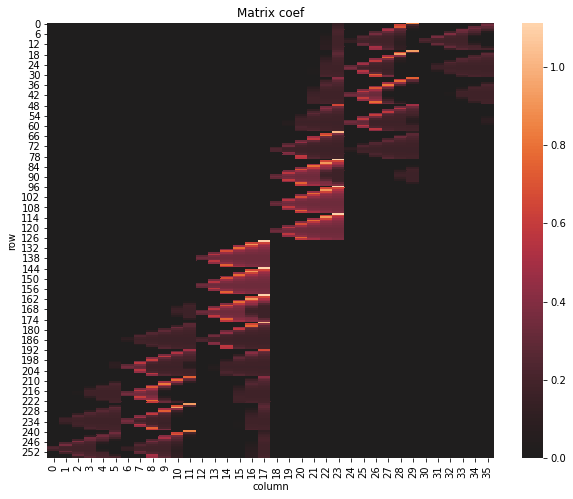

In [23]:
A = np.loadtxt(inputs[0])
A_inf, A_sup = make_interval(A, 0.001)
heatMap(A)

22
0
14


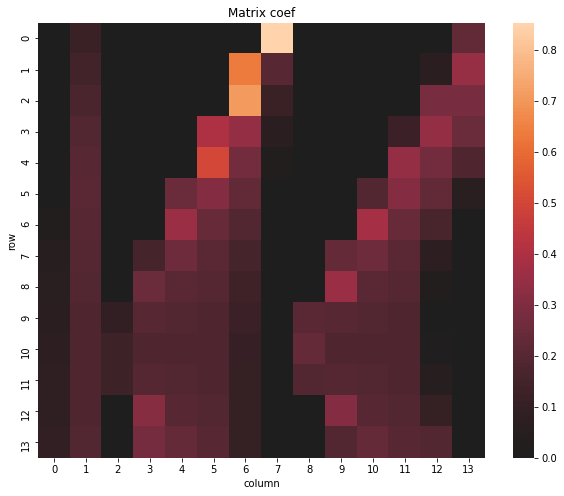

Too many iterations
Iteration count: 1001


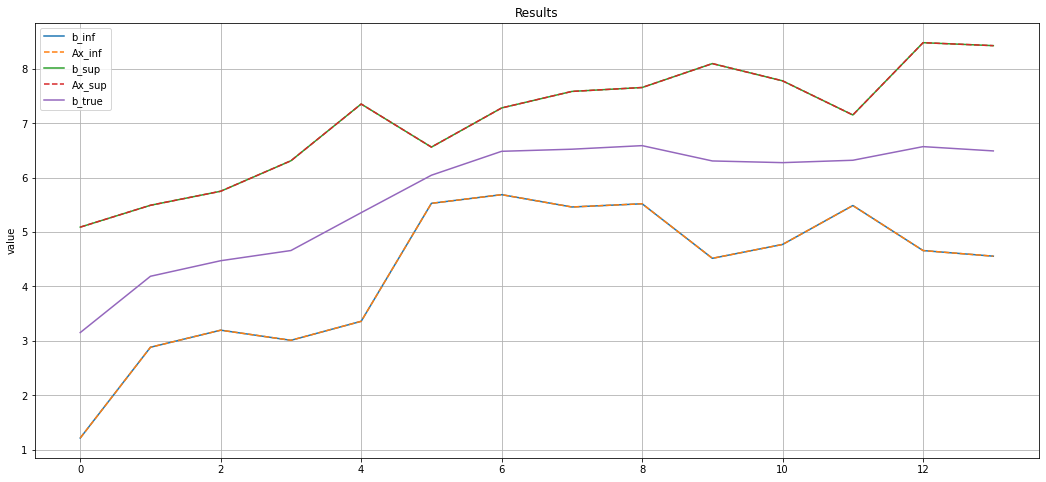

In [24]:
solve2(A, 15, 0.5)

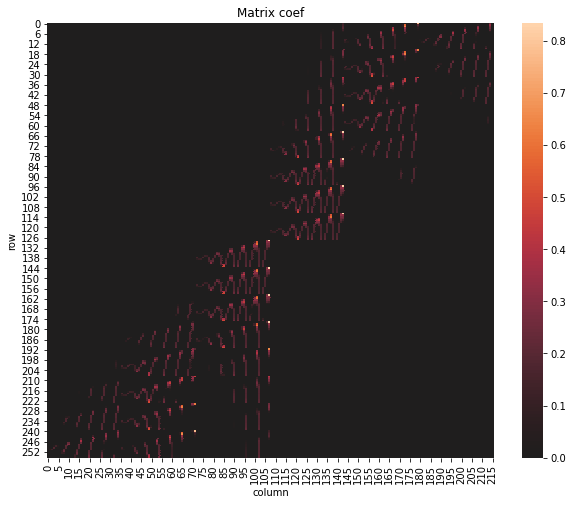

In [25]:
A = np.loadtxt(inputs[1])
A_inf, A_sup = make_interval(A, 0.001)
heatMap(A)

101
90
20


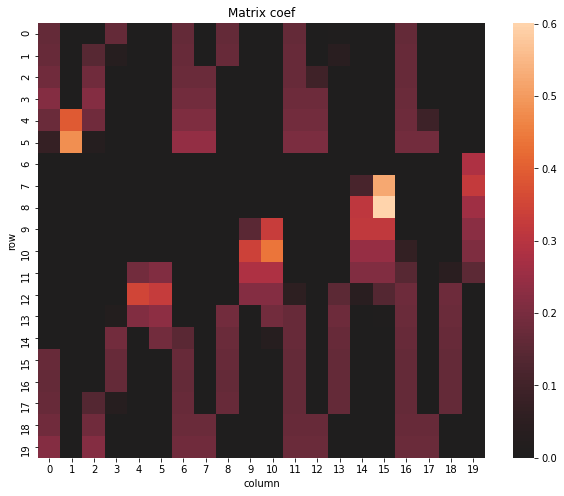

Iteration count: 92


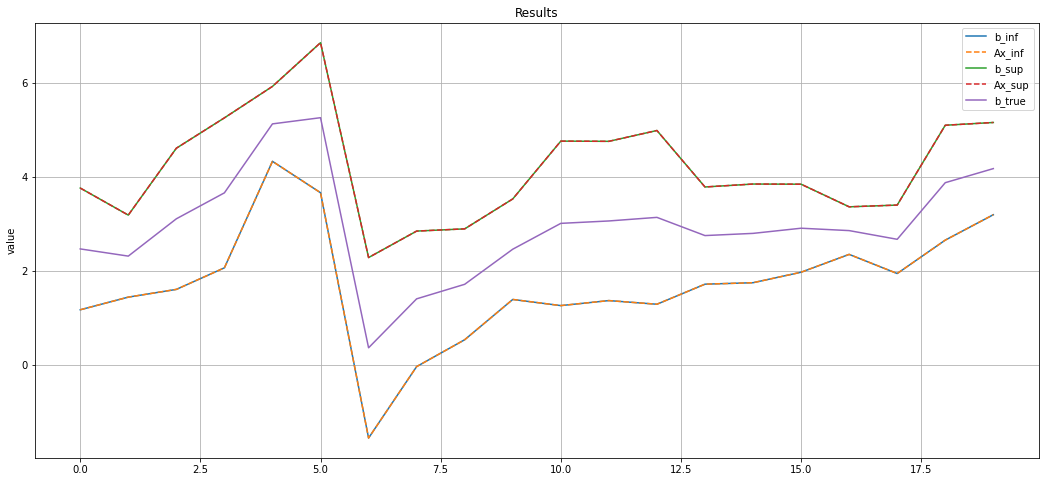

In [ ]:
solve2(A, 25, 0.8)

In [22]:
def interval_right_part(b):
    n = b.shape[0]
    rads = 0.5
    b_inf = b - rads  # make b interval
    b_sup = b + rads
    return b_inf, b_sup

In [23]:
def sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=0.08, acc=1e-8, max_iter=1000):
    
    n = A_inf.shape[0]  # dim
    
    A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
    A_blok = sti_dot_mtx(A_mid)
    sti_vec = sti_vector(b_inf, b_sup) 
    
    cur_x = np.zeros(sti_vec.shape[0]) 
    
    prev_x = cur_x
    started = False  


    cur_iter = 0
    worklist = [cur_x] 
    while not started or np.linalg.norm(cur_x - prev_x) > acc:
        started = True
        cur_iter += 1
        if (cur_iter > max_iter):
            print("Too many iterations")
            break
        prev_x = cur_x 
        D = np.zeros((2 * n, 2 * n)) 
        
        for i in range(n):
            for j in range(n):    
                
                h_inf = -prev_x[j]
                h_sup = prev_x[j + n]
                
                D = compute_sub_grad(D, i, j, A_inf, A_sup, h_inf, h_sup)
        
        
        f_v = compute_func_value(A_inf, A_sup, prev_x, sti_vec)

        dx = np.linalg.solve(D, -f_v)

        cur_x = prev_x + lr * dx

        worklist.append(cur_x)
        
    print(f"Iteration count: {cur_iter}")
    return back_sti_vector(cur_x), worklist

In [24]:
def solve3(matrix, size=25, lr=0.1):
    A, row = find_matrix(matrix, size)
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    s = np.loadtxt('/content/drive/My Drive/s36.txt')
    s = s[row:row+A.shape[0]]
    b = np.dot(A, s)  # get right part
    rads = 0.5
    b_inf = b - rads  # make b interval
    b_sup = b + rads

    #x, worklist = sub_diff_method(A_inf, A_sup, b_inf, b_sup, lr=lr)
    (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
    #interval_results(A_inf, A_sup, x[0], x[1], b_inf, b_sup, b)
    #plt.figure(figsize=(18, 8))
    #plt.plot(x, label='x')
    #plt.plot(s, label='s')
    #plt.title('Results')
    #plt.ylabel('value')
    #plt.grid()
    #plt.legend()
    #plt.show()
    n = s.shape[0]
    A_interval = [[Kaucher(A_inf[i,j], A_sup[i,j]) for j in range(n)] for i in range(n)]
    #x_inf = x[0]
    #x_sup = x[1]
    x_interval = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]
    X_inf = np.array([comp.lower for comp in x_interval])
    X_sup = np.array([comp.upper for comp in x_interval])
    plt.figure(figsize=(18, 8))
    plt.plot(X_inf, label='x_inf')
    plt.plot(X_sup, label='x_sup')
    plt.plot(s, label='s')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()
    print(f"X_inf: {x_inf}")
    print(f"X_sup: {x_sup}")
    print(f"S: {s}")

22
0
14


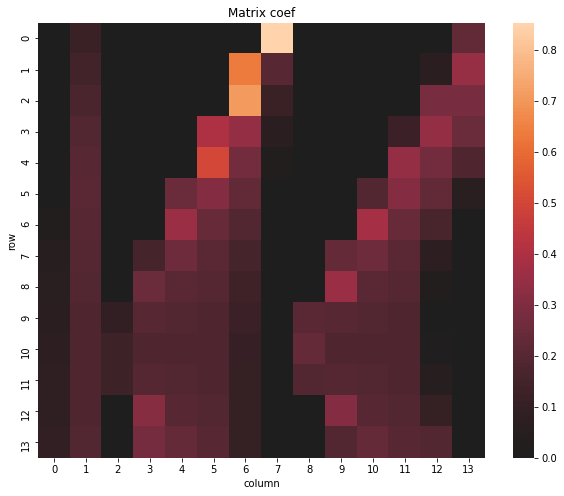

Iteration count: 40


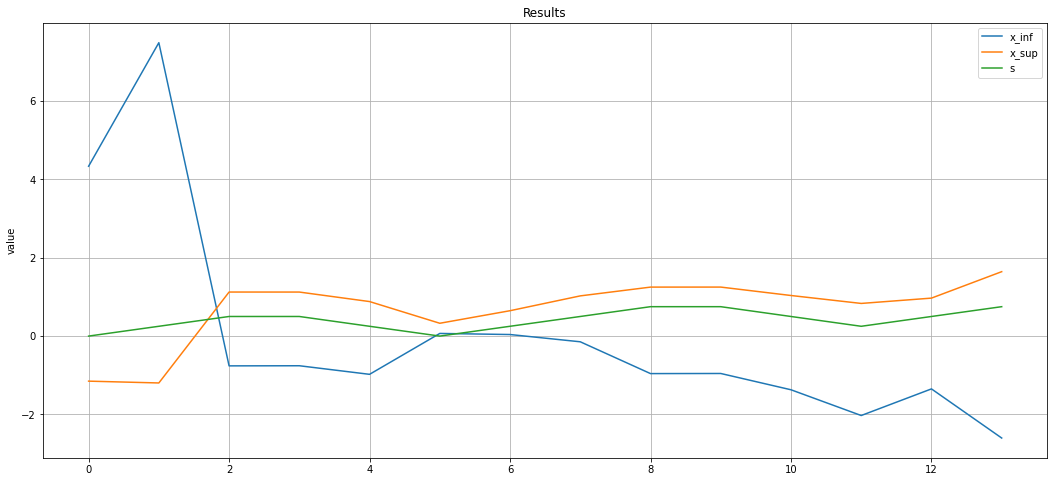

X_inf: [ 4.33301589  7.48473628 -0.75975485 -0.75670025 -0.97568959  0.06735285
  0.03972902 -0.14553203 -0.95688729 -0.95407841 -1.36959925 -2.0263884
 -1.34732256 -2.60079898]
X_sup: [-1.14949851 -1.19591086  1.12359948  1.12313864  0.88066682  0.32693305
  0.64724079  1.02550642  1.24953272  1.25004688  1.03532767  0.83295722
  0.96856392  1.64311029]
S: [0.   0.25 0.5  0.5  0.25 0.   0.25 0.5  0.75 0.75 0.5  0.25 0.5  0.75]


In [29]:
A = np.loadtxt(inputs[0])
solve3(A, 15, 0.5)

In [30]:
def shift(key, array):
    counter = range(len(array))
    new = counter
    for i in counter:
        new[i] = array[i-key]
    return new

In [60]:
def solve4(matrix, size=25, lr=0.1):
    A, row = find_matrix(matrix, size)
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    s = np.loadtxt('/content/drive/My Drive/s36.txt')
    s = s[row:row+A.shape[0]]
    b = np.dot(A, s)  # get right part
    rads = 0.5
    b_inf = b - rads  # make b interval
    b_sup = b + rads

    (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
    #print(f"X_inf: {x_inf}")
    #print(f"X_sup: {x_sup}")
    #print(f"S: {s}")

    #print(f"A_inf: {A_inf}")
    #print(f"A_sup: {A_sup}")
    #print(f"A[0,1]: {A[0][1]}")
    #print(f"A[13,1]: {A[-1][1]}")
    #print(f"A: {A}")
    
    #A_new = []
    #for r in range(14):
    #    A_new.append([])
    #    for c in range(14):
    #        A_new[r].append(0)

    Xx_inf = [[0 for i in range(14)] for j in range(15)]
    
    Xx_sup = [[0 for i in range(14)] for j in range(15)]
    
    Ss = [[0 for i in range(14)] for j in range(15)]

    for i in range(14):
      Xx_inf[14][i] = x_inf[i]
      Xx_sup[14][i] = x_sup[i]
      Ss[14][i] = s[i]
    
    #plt.figure(figsize=(18, 8))
    #plt.plot(s, label='s')

    for k in range(14):
      A_new = copy.deepcopy(A)
      s_new = copy.deepcopy(s)

      for i in range(14):
        for j in range(14):
          A_new[i][j] = A[i-1][j]
        s_new[i] = s[i-1]

      #heatMap(A_new)  
      A_inf, A_sup = make_interval(A_new, 0.001)
      b = np.dot(A_new, s_new)  # get right part
      rads = 0.5
      b_inf = b - rads  # make b interval
      b_sup = b + rads
      
      (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
      #print(f"X_inf: {x_inf}")
      #print(f"X_sup: {x_sup}")
      #print(f"S: {s_new}")
      for l in range(14):
        Xx_inf[k][l] = x_inf[l]
        Xx_sup[k][l] = x_sup[l]
        Ss[k][l] = s_new[l]
      A = copy.deepcopy(A_new)
      s = copy.deepcopy(s_new)
      strlabel = 's_'
      if k == 0:
        strlabel = 's_0'
      if k == 1:
        strlabel = 's_1'
      if k == 2:
        strlabel = 's_2'
      if k == 3:
        strlabel = 's_3'
      if k == 4:
        strlabel = 's_4'
      if k == 5:
        strlabel = 's_5'
      if k == 6:
        strlabel = 's_6'
      if k == 7:
        strlabel = 's_7'
      if k == 8:
        strlabel = 's_8'
      if k == 9:
        strlabel = 's_9'
      if k == 10:
        strlabel = 's_10'
      if k == 11:
        strlabel = 's_11'
      if k == 12:
        strlabel = 's_12'
      if k == 13:
        strlabel = 's_13'
      #plt.plot(s, label=strlabel)
    #plt.title('Results')
    #plt.ylabel('value')
    #plt.grid()
    #plt.legend()
    print(f"Xx_inf: {Xx_inf}")
    print(f"Xx_sup: {Xx_sup}")
    print(f"Ss: {Ss}")
    Xx_inff = [0 for i in range(14)]
    for i in range(14):
      Xx_inff[i] = Xx_inf[0][i]
    for i in range(15):
      for j in range(14):
        if Xx_inff[j] < Xx_inf[i][j]:
          Xx_inff[j] = Xx_inf[i][j]
    Xx_supf = [0 for i in range(14)]
    for i in range(14):
      Xx_supf[i] = Xx_sup[0][i]
    for i in range(15):
      for j in range(14):
        if Xx_supf[j] > Xx_sup[i][j]:
          Xx_supf[j] = Xx_sup[i][j]
    Ssf = [0 for i in range(14)]
    for i in range(15):
      for j in range(14):
        Ssf[j] = Ssf[j] + Ss[i][j]
    for i in range(14):
      Ssf[i] = Ssf[i] / 14
    print(f"Xx_inff: {Xx_inff}")
    print(f"Xx_supf: {Xx_supf}")
    print(f"Ssf: {Ssf}")
    #plt.show()

    n = s.shape[0]
    x_interval = [Kaucher(Xx_inff[i], Xx_supf[i]) for i in range(n)]
    X_inf = np.array([comp.lower for comp in x_interval])
    X_sup = np.array([comp.upper for comp in x_interval])
    plt.figure(figsize=(18, 8))
    plt.plot(X_inf, label='x_inf')
    plt.plot(X_sup, label='x_sup')
    plt.plot(Ssf, label='s')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()
    


22
0
14


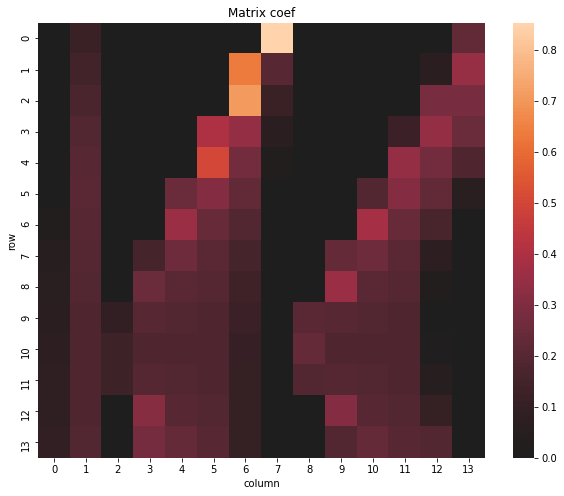

Iteration count: 40
Iteration count: 37
Iteration count: 49
Iteration count: 77
Iteration count: 43
Too many iterations
Iteration count: 1001
Iteration count: 66
Iteration count: 55
Iteration count: 126
Iteration count: 47
Too many iterations
Iteration count: 1001
Iteration count: 123
Iteration count: 170
Iteration count: 52
Iteration count: 40
Xx_inf: [[3.784336802930008, 5.203219187300188, -0.8274989579400516, -0.575595829055378, -0.6070276303870534, 0.009027462519743644, -0.42115370782920164, -0.43331516262574427, -0.6992003043198064, -0.44787458849983414, -0.5093171367277675, -1.0491509340472958, -1.018380979313685, -1.697799241961366], [1.2701891540943935, 1.9574939646442797, -0.6621939312009307, -0.4047226469034836, -0.23519127784570557, -0.07822985854015786, -0.3550090163189061, -0.6290714718455691, -0.08384516521937388, 0.1642669972627323, 0.46868923074680285, 0.4194432810753322, 0.2187921041028849, -0.14530864092500403], [1.9212693300814014, 2.971715309798609, -0.0164723745115

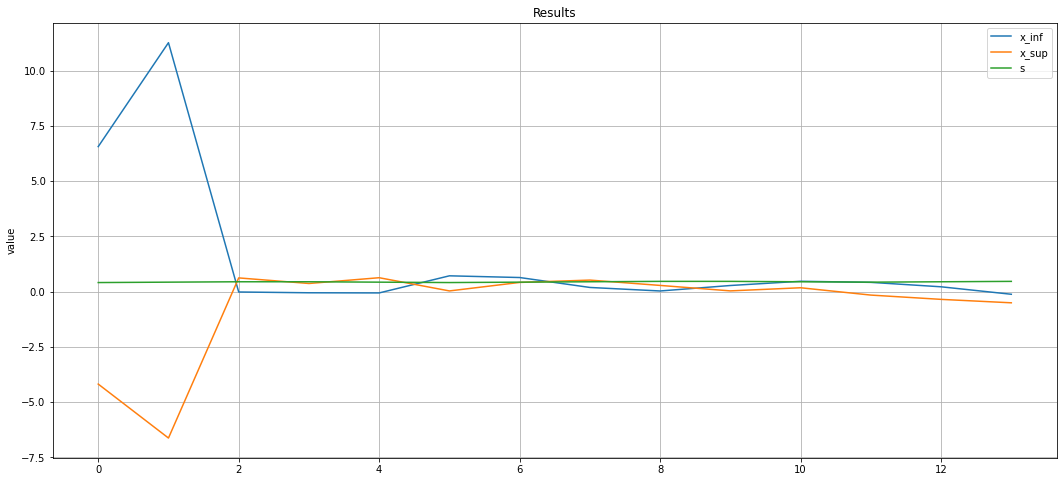

In [61]:
A = np.loadtxt(inputs[0])
solve4(A, 15, 0.5)

In [80]:
def solve5(matrix, size=25, lr=0.1):
    m = copy.deepcopy(matrix)
    A1, row = find_matrix(matrix, size)
    A = copy.deepcopy(A1)
    for i in range(14):
      for j in range(14):
        A[i][j] = matrix[i+66][j+16]
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    d = np.linalg.det(A)
    print(f"d: {d}")
    s = np.loadtxt('/content/drive/My Drive/s36.txt')
    s1 = copy.deepcopy(s)
    s2 = s[row:row+A.shape[0]]
    s = copy.deepcopy(s2)
    for i in range(14):
      s[i] = s1[i+16]
    b = np.dot(A, s)  # get right part
    rads = 0.5
    b_inf = b - rads  # make b interval
    b_sup = b + rads

    (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
    #print(f"X_inf: {x_inf}")
    #print(f"X_sup: {x_sup}")
    #print(f"S: {s}")

    #print(f"A_inf: {A_inf}")
    #print(f"A_sup: {A_sup}")
    #print(f"A[0,1]: {A[0][1]}")
    #print(f"A[13,1]: {A[-1][1]}")
    #print(f"A: {A}")
    
    #A_new = []
    #for r in range(14):
    #    A_new.append([])
    #    for c in range(14):
    #        A_new[r].append(0)

    Xx_inf = [[0 for i in range(14)] for j in range(15)]
    
    Xx_sup = [[0 for i in range(14)] for j in range(15)]
    
    Ss = [[0 for i in range(14)] for j in range(15)]

    for i in range(14):
      Xx_inf[14][i] = x_inf[i]
      Xx_sup[14][i] = x_sup[i]
      Ss[14][i] = s[i]
    
    #plt.figure(figsize=(18, 8))
    #plt.plot(s, label='s')

    for k in range(14):
      A_new = copy.deepcopy(A)
      s_new = copy.deepcopy(s)

      for i in range(14):
        for j in range(14):
          A_new[i][j] = A[i-1][j]
        s_new[i] = s[i-1]

      heatMap(A_new)  
      A_inf, A_sup = make_interval(A_new, 0.001)
      b = np.dot(A_new, s_new)  # get right part
      rads = 0.5
      b_inf = b - rads  # make b interval
      b_sup = b + rads
      
      (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
      #print(f"X_inf: {x_inf}")
      #print(f"X_sup: {x_sup}")
      #print(f"S: {s_new}")
      for l in range(14):
        Xx_inf[k][l] = x_inf[l]
        Xx_sup[k][l] = x_sup[l]
        Ss[k][l] = s_new[l]
      A = copy.deepcopy(A_new)
      s = copy.deepcopy(s_new)
      strlabel = 's_'
      if k == 0:
        strlabel = 's_0'
      if k == 1:
        strlabel = 's_1'
      if k == 2:
        strlabel = 's_2'
      if k == 3:
        strlabel = 's_3'
      if k == 4:
        strlabel = 's_4'
      if k == 5:
        strlabel = 's_5'
      if k == 6:
        strlabel = 's_6'
      if k == 7:
        strlabel = 's_7'
      if k == 8:
        strlabel = 's_8'
      if k == 9:
        strlabel = 's_9'
      if k == 10:
        strlabel = 's_10'
      if k == 11:
        strlabel = 's_11'
      if k == 12:
        strlabel = 's_12'
      if k == 13:
        strlabel = 's_13'
      #plt.plot(s, label=strlabel)
    #plt.title('Results')
    #plt.ylabel('value')
    #plt.grid()
    #plt.legend()
    print(f"Xx_inf: {Xx_inf}")
    print(f"Xx_sup: {Xx_sup}")
    print(f"Ss: {Ss}")
    Xx_inff = [0 for i in range(14)]
    for i in range(14):
      Xx_inff[i] = Xx_inf[0][i]
    for i in range(15):
      for j in range(14):
        if Xx_inff[j] < Xx_inf[i][j]:
          Xx_inff[j] = Xx_inf[i][j]
    Xx_supf = [0 for i in range(14)]
    for i in range(14):
      Xx_supf[i] = Xx_sup[0][i]
    for i in range(15):
      for j in range(14):
        if Xx_supf[j] > Xx_sup[i][j]:
          Xx_supf[j] = Xx_sup[i][j]
    Ssf = [0 for i in range(14)]
    for i in range(15):
      for j in range(14):
        Ssf[j] = Ssf[j] + Ss[i][j]
    for i in range(14):
      Ssf[i] = Ssf[i] / 14
    print(f"Xx_inff: {Xx_inff}")
    print(f"Xx_supf: {Xx_supf}")
    print(f"Ssf: {Ssf}")
    #plt.show()

    n = s.shape[0]
    x_interval = [Kaucher(Xx_inff[i], Xx_supf[i]) for i in range(n)]
    X_inf = np.array([comp.lower for comp in x_interval])
    X_sup = np.array([comp.upper for comp in x_interval])
    plt.figure(figsize=(18, 8))
    plt.plot(X_inf, label='x_inf')
    plt.plot(X_sup, label='x_sup')
    plt.plot(Ssf, label='s')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()
    


22
0
14


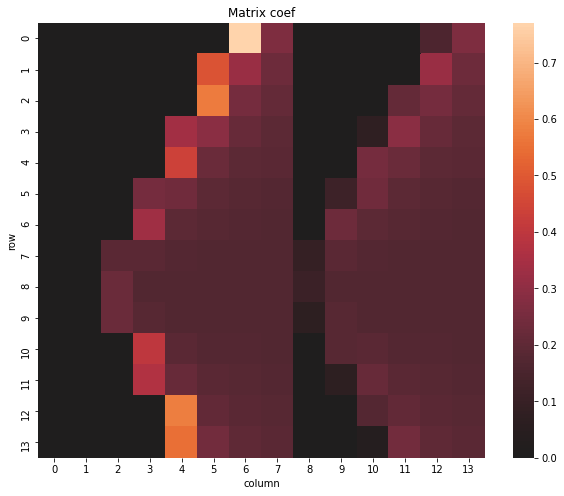

d: 0.0


LinAlgError: ignored

In [81]:
A = np.loadtxt(inputs[0])
solve5(A, 15, 0.5)

In [83]:
def solve6(matrix, size=25, lr=0.1):
    A, row = find_matrix(matrix, size)
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    s = np.loadtxt('/content/drive/My Drive/s216.txt')
    s = s[row:row+A.shape[0]]
    b = np.dot(A, s)  # get right part
    rads = 0.5
    b_inf = b - rads  # make b interval
    b_sup = b + rads

    (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
    #print(f"X_inf: {x_inf}")
    #print(f"X_sup: {x_sup}")
    #print(f"S: {s}")

    #print(f"A_inf: {A_inf}")
    #print(f"A_sup: {A_sup}")
    #print(f"A[0,1]: {A[0][1]}")
    #print(f"A[13,1]: {A[-1][1]}")
    #print(f"A: {A}")
    
    #A_new = []
    #for r in range(14):
    #    A_new.append([])
    #    for c in range(14):
    #        A_new[r].append(0)

    Xx_inf = [[0 for i in range(20)] for j in range(21)]
    
    Xx_sup = [[0 for i in range(20)] for j in range(21)]
    
    Ss = [[0 for i in range(20)] for j in range(21)]

    for i in range(14):
      Xx_inf[20][i] = x_inf[i]
      Xx_sup[20][i] = x_sup[i]
      Ss[20][i] = s[i]
    
    #plt.figure(figsize=(18, 8))
    #plt.plot(s, label='s')

    for k in range(20):
      A_new = copy.deepcopy(A)
      s_new = copy.deepcopy(s)

      for i in range(20):
        for j in range(20):
          A_new[i][j] = A[i-1][j]
        s_new[i] = s[i-1]

      #heatMap(A_new)  
      A_inf, A_sup = make_interval(A_new, 0.001)
      b = np.dot(A_new, s_new)  # get right part
      rads = 0.5
      b_inf = b - rads  # make b interval
      b_sup = b + rads
      
      (x_inf, x_sup), worklist = sub_diff_method2(A_inf, A_sup, b_inf, b_sup, lr=lr)
      #print(f"X_inf: {x_inf}")
      #print(f"X_sup: {x_sup}")
      #print(f"S: {s_new}")
      for l in range(20):
        Xx_inf[k][l] = x_inf[l]
        Xx_sup[k][l] = x_sup[l]
        Ss[k][l] = s_new[l]
      A = copy.deepcopy(A_new)
      s = copy.deepcopy(s_new)
      strlabel = 's_'
      if k == 0:
        strlabel = 's_0'
      if k == 1:
        strlabel = 's_1'
      if k == 2:
        strlabel = 's_2'
      if k == 3:
        strlabel = 's_3'
      if k == 4:
        strlabel = 's_4'
      if k == 5:
        strlabel = 's_5'
      if k == 6:
        strlabel = 's_6'
      if k == 7:
        strlabel = 's_7'
      if k == 8:
        strlabel = 's_8'
      if k == 9:
        strlabel = 's_9'
      if k == 10:
        strlabel = 's_10'
      if k == 11:
        strlabel = 's_11'
      if k == 12:
        strlabel = 's_12'
      if k == 13:
        strlabel = 's_13'
      #plt.plot(s, label=strlabel)
    #plt.title('Results')
    #plt.ylabel('value')
    #plt.grid()
    #plt.legend()
    print(f"Xx_inf: {Xx_inf}")
    print(f"Xx_sup: {Xx_sup}")
    print(f"Ss: {Ss}")
    Xx_inff = [0 for i in range(20)]
    for i in range(20):
      Xx_inff[i] = Xx_inf[0][i]
    for i in range(21):
      for j in range(20):
        if Xx_inff[j] < Xx_inf[i][j]:
          Xx_inff[j] = Xx_inf[i][j]
    Xx_supf = [0 for i in range(20)]
    for i in range(20):
      Xx_supf[i] = Xx_sup[0][i]
    for i in range(21):
      for j in range(20):
        if Xx_supf[j] > Xx_sup[i][j]:
          Xx_supf[j] = Xx_sup[i][j]
    Ssf = [0 for i in range(20)]
    for i in range(21):
      for j in range(20):
        Ssf[j] = Ssf[j] + Ss[i][j]
    for i in range(20):
      Ssf[i] = Ssf[i] / 20
    print(f"Xx_inff: {Xx_inff}")
    print(f"Xx_supf: {Xx_supf}")
    print(f"Ssf: {Ssf}")
    #plt.show()

    n = s.shape[0]
    x_interval = [Kaucher(Xx_inff[i], Xx_supf[i]) for i in range(n)]
    X_inf = np.array([comp.lower for comp in x_interval])
    X_sup = np.array([comp.upper for comp in x_interval])
    plt.figure(figsize=(18, 8))
    plt.plot(X_inf, label='x_inf')
    plt.plot(X_sup, label='x_sup')
    plt.plot(Ssf, label='s')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()
    


101
90
20


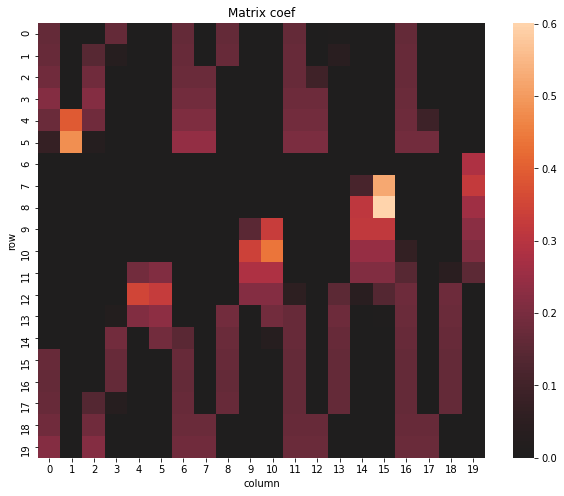

Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Iteration count: 15
Xx_inf: [[-3.2838209951679267, 0.7150984611919201, 4.05699004445343, 4.028539959725855, 4.3211532263898045, -2.6352312805389797, 2.393911536158775, 6.506922314268069, 6.538967103124057, -0.07652630424698675, 1.1721758907089774, -9.260022474882486, 0.7475393075307649, 0.4962737317919948, -0.09263254588488894, 0.7484762998269265, 1.3569373554856414, 0.48172325184045456, 0.4828494903782671, -1.1711376950271748], [-3.2978043154340475, 0.21400438530080024, 4.06788583693794, 4.039358595230468, 4.333837940534034, -2.6486569271240255, 2.398859825037811, 6.769537967043672, 6.5502310

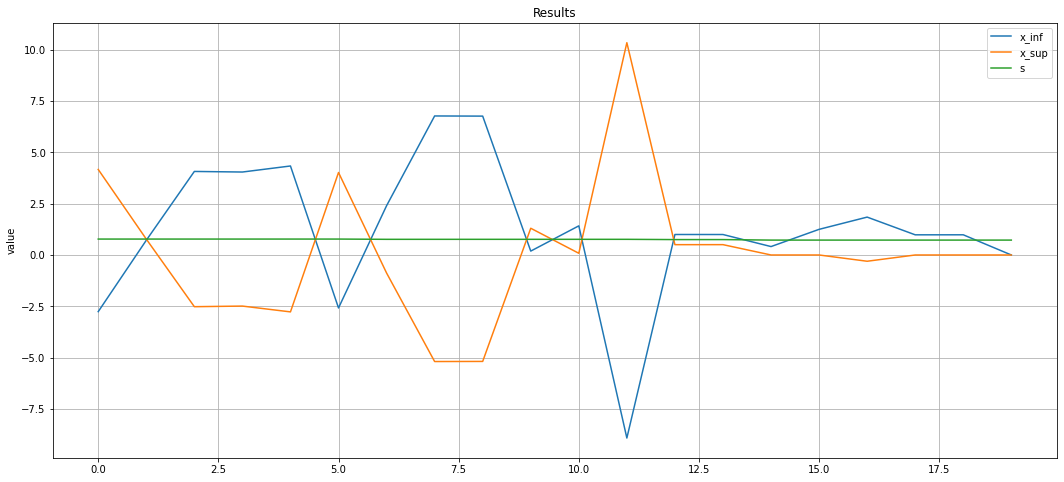

In [84]:
A = np.loadtxt(inputs[1])
solve6(A, 25, 0.8)